<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-2-mg-ext/11-multigrid-2d-line-relaxation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

### A stencil operator

In [2]:
def stencil_grid(S, grid):
    N_v = np.prod(grid)  # number of vertices in the mesh
    N_s = (S != 0).sum() # number of nonzero stencil entries

    # diagonal offsets
    diags = np.zeros(N_s, dtype=int)

    # compute index offset of each dof within the stencil
    strides = np.cumprod([1] + list(reversed(grid)))[:-1]
    indices = tuple(i.copy() for i in S.nonzero())
    for i, s in zip(indices, S.shape):
        i -= s // 2

    for stride, coords in zip(strides, reversed(indices)):
        diags += stride * coords

    data = S[S != 0].repeat(N_v).reshape(N_s, N_v)

    indices = np.vstack(indices).T

    # zero boundary connections
    for index, diag in zip(indices, data):
        diag = diag.reshape(grid)
        for n, i in enumerate(index):
            if i > 0:
                s = [slice(None)] * len(grid)
                s[n] = slice(0, i)
                s = tuple(s)
                diag[s] = 0
            elif i < 0:
                s = [slice(None)]*len(grid)
                s[n] = slice(i, None)
                s = tuple(s)
                diag[s] = 0

    # remove diagonals that lie outside matrix
    mask = abs(diags) < N_v
    if not mask.all():
        diags = diags[mask]
        data = data[mask]

    # sum duplicate diagonals
    if len(np.unique(diags)) != len(diags):
        new_diags = np.unique(diags)
        new_data = np.zeros((len(new_diags), data.shape[1]),
                            dtype=data.dtype)

        for dia, dat in zip(diags, data):
            n = np.searchsorted(new_diags, dia)
            new_data[n, :] += dat

        diags = new_diags
        data = new_data

    return sparse.dia_matrix((data, diags), shape=(N_v, N_v)).tocsr()

### A tridiagonal solver

In [3]:
def trisolver(a, b, c, rhs):
    '''
    https://gist.github.com/TheoChristiaanse/d168b7e57dd30342a81aa1dc4eb3e469
    '''
    nf = len(rhs) # number of equations
    ac, bc, cc, rhsc = map(np.array, (a, b, c, rhs)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1] / bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        rhsc[it] = rhsc[it] - mc*rhsc[it-1]   
    xc = bc
    xc[-1] = rhsc[-1] / bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (rhsc[il] - cc[il] * xc[il+1]) / bc[il]

    return xc

### Point relaxation, interpolation, and an operator

Here, the diffusion operator uses a `sten` as input...

In [4]:
def pointrelax(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    Dinv = sparse.spdiags(1./A.diagonal(), [0], n, n)
    omega = 4 / 5

    for i in range(nu):
        unew += omega * Dinv * (f - A * unew)
        
    return unew

def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc), dtype=int)
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

def poissonop(n, sten):
    #sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    A = stencil_grid(sten, (n, n))
    return A

def getsten(epsilon):
    sten = np.array([[ 0      ,           -1.,  0],
                     [-epsilon,  2+2*epsilon, -epsilon],
                     [0       ,           -1,  0]])
    return sten

In [5]:
def linerelax(A, u, f, nu,
              sten,
              direction='y'):
    """
    'y' -- constant x
    'x' -- constant y
    """
    n = int(np.sqrt(len(f))) # assume a square grid
    
    # get the stride
    # linesten -- the stencil for the 1d problem
    # offsten -- the weak stencil entries
    if direction == 'x':
        stride = 1
        linesten = sten[1,:]
        offsten = sten[[0,2],1]
    if direction == 'y':
        stride = n
        linesten = sten[:,1]
        offsten = sten[1,[0,2]]
    
    # build the three vectors for the tridiagonal solver
    T = np.array(linesten) * np.ones((n,3))
    
    f = f.reshape((n,n))
    unew = u.copy()
    unew = unew.reshape((n,n))
    
    # for each smoothing pass
    for _ in range(nu):
        # solve each line
        for i in range(n):
            if direction == 'x':
                fline = f[i,:].copy()
                if i > 1:
                    fline -= offsten[0] * unew[i-1,:]
                if i < (n-1):
                    fline -= offsten[1] * unew[i+1,:]

            if direction == 'y':
                fline = f[:,i].copy()
                if i > 1:
                    fline -= offsten[0] * unew[:,i-1]
                if i < (n-1):
                    fline -= offsten[1] * unew[:,i+1]

            uline = trisolver(T[:,0], T[:,1], T[:,2], fline)

            if direction == 'x':
                unew[i,:] = uline
            if direction == 'y':
                unew[:,i] = uline
    return unew.ravel()

### Try smoothing

Here we will try the line smoother.

Flip back and forth between point smoothing and line smoothing.

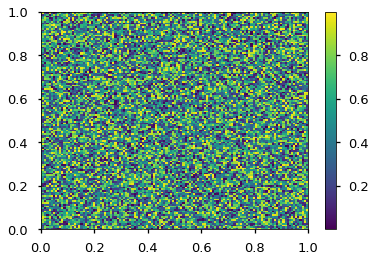

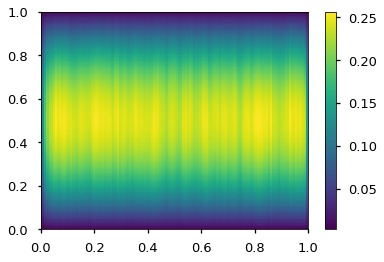

In [6]:
k = 7
n = 2**k - 1
nc = 2**(k-1) - 1
X, Y = np.meshgrid(np.linspace(0,1,n),
                   np.linspace(0,1,n))

u = np.random.rand(n,n).ravel()
f = np.zeros((n,n)).ravel()

epsilon = 0.001
sten = getsten(epsilon)
A = (n+1)**2 * poissonop(n, sten)

plt.figure()
plt.pcolormesh(X, Y, u.reshape((n,n)))
plt.colorbar()
u = linerelax(A, u, f, 2, (n+1)**2*sten, direction='y')
#u = pointrelax(A, u, f, 10)
plt.figure()
plt.pcolormesh(X, Y, u.reshape((n,n)))
plt.colorbar()

### Define a two grid cycle

As a reminder, flip back and forth between `pointrelax` and `linerelax`

In [7]:
def twogrid(A, P, A1, u0, f0, nu, sten=None):
    #u0 = pointrelax(A, u0, f0, nu)
    u0 = linerelax(A, u0, f0, nu, sten, direction='y')
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    #u0 = pointrelax(A, u0, f0, nu)
    u0 = linerelax(A, u0, f0, nu, sten, direction='y')
    return u0

### Run it 

Here we'll run it a few times and then observe the output

In [8]:
u = np.random.rand(n*n)
f = np.zeros((n,n)).ravel()
epsilon = 0.01
sten = getsten(epsilon)
A = (n+1)**2 * poissonop(n, sten)
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()
A1 = P.T * A * P

m = 20
res = []
for j in range(m):
    u = twogrid(A, P, A1, u, f, 1, (n+1)**2 * sten)
    res.append(np.linalg.norm(f - A * u))
    
res = np.array(res)
factor = (res[-1] / res[-5])**(1/5)
print(factor)

0.1883971209382412


### Try it for different $\varepsilon$

Let's vary $\varepsilon$ and see what happens

In [9]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
elist = np.logspace(-3,3,50)
allres = np.zeros((len(elist),m))
m = 20

for i, epsilon in enumerate(elist):
    u = np.random.rand(n*n)
    f = np.zeros((n,n)).ravel()
    sten = getsten(epsilon)
    
    A = (n+1)**2 * poissonop(n, sten)
    P1d = interpolation1d(nc, n)
    P = sparse.kron(P1d, P1d).tocsr()
    A1 = P.T * A * P
    for j in range(m):
        u = twogrid(A, P, A1, u, f, 1, (n+1)**2 * sten)
        res = np.linalg.norm(f - A * u)
        allres[i,j] = res

Text(0, 0.5, 'norm of the residual')

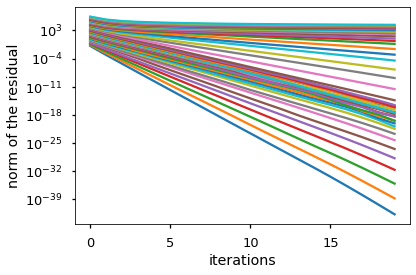

In [10]:
for i in range(len(elist)):
    plt.semilogy(allres[i,:])
plt.xlabel('iterations')
plt.ylabel('norm of the residual')

Text(0, 0.5, 'convergence factor')

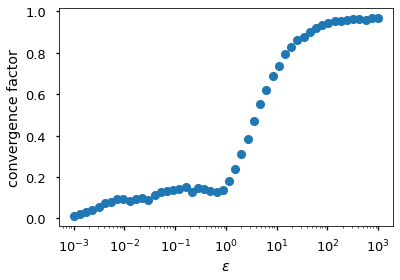

In [11]:
factors = []
for i in range(len(elist)):    
    factor = (allres[i,-1] / allres[i,-5])**(1/5)
    factors.append(factor)

plt.semilogx(elist, factors, 'o')
plt.xlabel('$\epsilon$')
plt.ylabel('convergence factor')

### What happens to the spectrum?

Here we'll apply line relaxation to the sine waves again.

In [28]:
epsilon = 0.1 * 1/n
sten = getsten(epsilon)
A = poissonop(n, sten)

f = np.zeros((n,n)).ravel()
z = np.zeros((n,n))
for k1 in range(1,n+1):
    for k2 in range(1,n+1):
        v = np.outer(np.sin(np.arange(1,n+1) * k1 * np.pi / (n+1)),
                     np.sin(np.arange(1,n+1) * k2 * np.pi / (n+1)))
        v = v.ravel()
        nv0 = np.linalg.norm(v)
        m = 10
        #v = pointrelax(A, v, f, m)
        v = linerelax(A, v, f, m, sten, direction='y')
        nv1 = np.linalg.norm(v)
        z[k1-1,k2-1] = (nv1 / nv0)**(1/m)

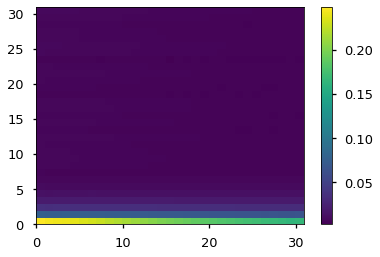

In [29]:
plt.pcolor(z)
plt.colorbar()

### Notice highly oscillatory waves in the x-direction

In [14]:
X, Y = np.meshgrid(np.linspace(0,1,n),
                   np.linspace(0,1,n))
v = np.outer(np.sin(np.arange(1,n+1) * 1 * np.pi / (n+1)),
             np.sin(np.arange(1,n+1) * 28 * np.pi / (n+1)))
print(v.shape)
v = linerelax(A, v, f, 1, sten, direction='y')
print(v.shape)

(31, 31)
(961,)


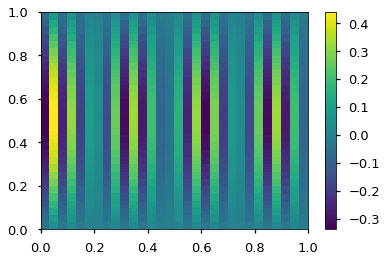

In [15]:
plt.pcolor(X, Y, v.reshape((n,n)))
plt.colorbar()

### Fixing all $\varepsilon$

Let's line relax in **both** directions, to take care of anisotropies.

In [ ]:
def twogrid(A, P, A1, u0, f0, nu, sten=None):
    #u0 = pointrelax(A, u0, f0, nu)
    u0 = linerelax(A, u0, f0, nu, sten, direction='y')
    u0 = linerelax(A, u0, f0, nu, sten, direction='x')
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    #u0 = pointrelax(A, u0, f0, nu)
    u0 = linerelax(A, u0, f0, nu, sten, direction='y')
    u0 = linerelax(A, u0, f0, nu, sten, direction='x')
    return u0

In [ ]:
k = 5
n = 2**k - 1
nc = 2**(k-1) - 1
elist = np.logspace(-3,3,50)
m=20
allres = np.zeros((len(elist),m))

for i, epsilon in enumerate(elist):
    u = np.random.rand(n*n)
    f = np.zeros((n,n)).ravel()
    sten = getsten(epsilon)
    A = (n+1)**2 * poissonop(n, sten)
    P1d = interpolation1d(nc, n)
    P = sparse.kron(P1d, P1d).tocsr()
    A1 = P.T * A * P
    for j in range(m):
        u = twogrid(A, P, A1, u, f, 1, (n+1)**2 * sten)
        res = np.linalg.norm(f - A * u)
        allres[i,j] = res

In [ ]:
for i in range(len(elist)):
    plt.semilogy(allres[i,:])
plt.xlabel('iterations')
plt.ylabel('norm of the residual')

In [ ]:
factors = []
for i in range(len(elist)):    
    factor = (allres[i,-1] / allres[i,-5])**(1/5)
    factors.append(factor)

plt.semilogx(elist, factors, 'o')
plt.xlabel('$\epsilon$')
plt.ylabel('convergence factor')